<a href="https://colab.research.google.com/github/xaximpvp2/master/blob/main/codigo_aula_21_Dicas_para_implementar_e_testar_metodos_e_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dicas para implementar/testar métodos e modelos


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Avaliando um algoritmo de aprendizado (Regressão Polinomial)

Vamos supor que você criou um modelo de aprendizado de máquina que aproxima muito bem os dados de estimação. Isso é sufuciente para dizer que esse modelo é de fato bom? Não, conforme vimos na teoria, o objetivo é criar um modelo que seja capaz de prever valores para <span style="color:blue">*novas* </span> amostras.

Mas como podemos então avaliar a qualidade do nosso modelo?   
* Passo 1) Divida seus dados originais em dados para "treinamento" e dados para "teste"
    * Use os dados de treinamento para ajustar os parâmetros do modelo
    * Use os dados de teste para avaliar a qualidade do modelo para *novos* dados
* Passo 2) Desenvolva uma função (métrica) para avaliar a qualidade do modelo.

### Dividindo os dados em subconjuntos
É interessante separarmos algo entre 20-40% dos dados para teste. Abaixo nós usamos a função do `sklearn` [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para separarmos os dados.

Cheque os shapes resultantes para conferir os resultados.

In [2]:
# gerando dados com base em valores do tipo x^2 com adição de ruído
seed    = 2  # semente do gerador de números aleatórios
escala  = 0.7 # escala do ruído
m       = 18  # número de amostras
X       = np.linspace(0,49,m)
np.random.seed(seed)
y_ideal = X**2
y       = y_ideal + escala * y_ideal*(np.random.sample((m,))-0.5)
x_ideal = X

print("X.shape", X.shape, "y.shape", y.shape)

# dividindo os dados usando sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1) # 33% dos dados irão para o conjunto de dados de teste
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### Plotando os dados

Abaixo você pode ver as amostras que farão parte dos dados de treinamento e as amostras que farão parte dos dados de teste. Note que eles estão misturados durante todo o intervalo de x, que está entre 0 e 49. Esse conjunto de dados representa uma função quadrática com ruído. A curva ideal é mostrada apenas para termos ela como referência.

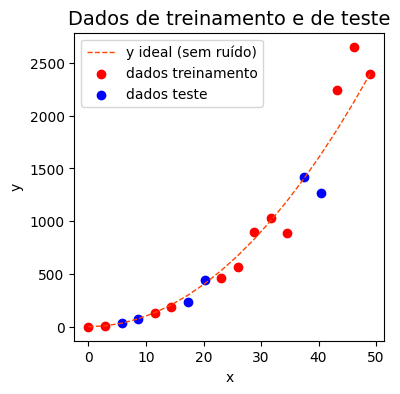

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y ideal (sem ruído)", lw=1)
ax.set_title("Dados de treinamento e de teste",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",    label="dados treinamento")
ax.scatter(X_test, y_test,   color = "blue",   label="dados teste")
ax.legend(loc='upper left')
plt.show()


### Cálculo do erro para avaliar a qualidade do modelo (regressão linear)

Para avaliar a qualidade de um modelo de regressão linear, você pode usar a média dos erros quadráticos existentes entre os valores alvo e os valores previstos pelo modelo.

$$ J_\text{teste}(\mathbf{w},b) =
            \frac{1}{2m_\text{teste}}\sum_{i=0}^{m_\text{teste}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{teste}) - y^{(i)}_\text{teste} )^2
            \tag{1}
$$

Essa função é também chamada de Erro Quadrático Médio (ou MSE, do inglês, mean squared error). Abaixo implementação que automatiza o cálculo do MSE.

Observação: Em algumas referências, o MSE não aparece dividido por 2.

In [4]:
def calcula_MSE(y, yhat):
    """
    Calcula o MSE para um conjunto de valores alvo (y) e estimativas para esses valores (yhat).
    Argumentos:
      y    : (ndarray  Shape (m,) or (m,1))  valores alvo
      yhat : (ndarray  Shape (m,) or (m,1))  estimativas para os valores alvo
    Retorna:
      erro: (escalar)
    """
    m    = len(y)
    erro = 0.0
    for i in range(m):
        erro += (y[i]-yhat[i])**2
    erro /= 2*m
    return(erro)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
erro = calcula_MSE(y_hat, y_tmp)

print(erro)

0.0050000000000000305


Na célula acima, teste diferentes sequências numéricas para verificar seu entendimento acerca do MSE

### Comparando a performance do modelo com base nos dados de treinamento e de teste

Com os conhecimento que já adquirimos em aulas anteriores, vamos construir um modelo polinomial de ordem elevada que busca minimizar o erro de treinamento. Usaremos para isso as funções da biblioteca linear_regression do `sklearn`.

Como usaremos as funções do sklearn diversas vezes e de forma repetida, torna-se mais fácil e prático criarmos uma `classe` que organiza e estrutura a chamada dessas funções.

Criamos a classe `lin_model` na célula abaixo.

In [6]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class lin_model: # cria uma classe com os atributos abaixo
    def __init__(self, degree, regularization = False, lambda_=0): # define como a classe é inicializada
        if regularization: # caso tenha regularização
            self.linear_model = Ridge(alpha=lambda_) # Define que queremos regressão linear com regularização. Na função Ridge do Scikit-Learn, alpha é o parâmetro de regularização, ou seja, é o nosso lambda.
        else:              # caso não tenha regularização
            self.linear_model = LinearRegression() # Define que queremos apenas "regressão linear" (sem regularização).
        self.poly   = PolynomialFeatures(degree, include_bias=False) # Cria uma função que gera características polinomiais
        self.scaler = StandardScaler() # Cria a possibilidade de normalização z-Score

    def fit(self, X_train,y_train): # aqui definimos o que ocorrerá sempre que fizermos modelo_linear.fit
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1)) # gerando as características polinomiais para os dados em X_train
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped) # Escalona os dados
        self.linear_model.fit(X_train_mapped_scaled, y_train ) # Ajusta os parâmetros do modelo

    def predict(self, X): # aqui definimos o que ocorrerá sempre que fizermos modelo_linear.predict
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)

    def mse(self, y, yhat): # aqui definimos o que ocorrerá sempre que fizermos modelo_linear.mse
        err = mean_squared_error(y,yhat)/2   # a função mean_squared_error do sklearn não possui, nativamente, o divididos por 2
        return (err)

Abaixo faremos o uso da classe criada. Note que estamos seguindo o seguinte passo-a-passo:
* criamos e estimamos o modelo. ('fit' é o nome da função que treina o modelo via Método do gradiente ou equação normal).
* calculamos o erro associado aos dados de treinamento.
* calculamos o erro associado aos dados de teste.

In [7]:
# cria um modelo no sklearn e treina com base nos dados de treinamento
degree = 10     # grau do polinomio
modelo = lin_model(degree)
modelo.fit(X_train, y_train)

# Faz previsão para os dados de treinamento e encontra o erro de treinamento J_trein, aqui chamado de 'erro_train'
yhat       = modelo.predict(X_train)
erro_trein = modelo.mse(y_train, yhat)

# Faz previsão para os dados de teste e encontra o erro de teste J_teste, aqui chamado de 'erro_teste'
yhat       = modelo.predict(X_test)
erro_teste = modelo.mse(y_test, yhat)

O código abaixo mostra que o erro calculado para os dados de treinamento é substancialmente menor do que aquele obtido para os dados de teste.

In [8]:
print(f"erro de treinamento: {erro_trein:0.2f}, erro de teste: {erro_teste:0.2f}")

erro de treinamento: 58.01, erro de teste: 171215.01


A figura a seguir mostra porquê isso aconteceu. O modelo ajusta os dados de treinamento muito bem. Para fazer isso, entretanto, uma função bastante complexa foi criada.

Os dados de teste não fazem parte do treinamento e o modelo não se sai bem ao realizar previsão com esses novos dados.

Esse modelo está sobreestimando os dados de estimação (overfitting), o que significa que ele possui uma alta variância e, portanto, não possui boa capacidade de generalização.

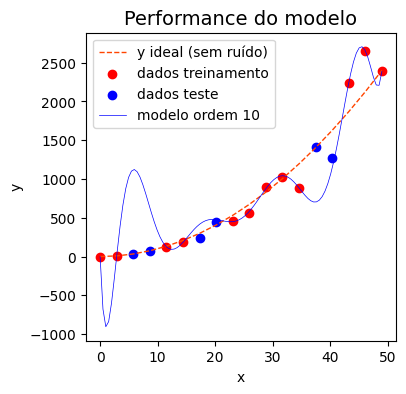

In [9]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y ideal (sem ruído)", lw=1)
ax.set_title("Performance do modelo",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",    label="dados treinamento")
ax.scatter(X_test, y_test,   color = "blue",   label="dados teste")

x     = np.linspace(0,int(X.max()),100)        # cria 100 valores diferentes para x linearmente distrubuídos entre [0 X_max]
yhat  = modelo.predict(x).reshape(-1,1)        # cálculo da saída do modelo para diversos valores diferentes para x
ax.plot(x, yhat, "-",   color = "blue",   label="modelo ordem 10", lw=0.5)

ax.legend(loc='upper left')
plt.show()

O erro de teste mostra que esse modelo não funciona bem para novos dados. Se você usar o erro de teste como guia para melhorar o modelo, então o modelo irá performar bem nos dados de teste... porém, isso não seria uma boa prática, já que os dados de teste devem representar *dados nunca vistos anteriormente pelo modelo*. Portanto, precisamos ainda de um novo conjunto de dados que sirva para testar a performance para um conjunto de dados que não seja o de treinamento, mas que também não seja o conjunto de teste final.

Conforme vimos na parte teórica da aula, a ideia é dividirmos os dados em três grupos. A distribuição mostrada abaixo é uma distribuição típica, mas pode variar dependendo da quantidade de dados disponíveis.

| dados            | % do total | Descrição |
|------------------|:----------:|:---------|
| treinamento         | 60         | Dados usados para ajustar os parâmetros $w$ e $b$ do modelo durante o seu treinamento |
| validação-cruzada | 20         | Dados usados para ajustar outros parâmetros do modelo (hiperparâmetros) como, por exemplo, grau do polinômio, parâmetro de regularização, ou arquitetura de uma rede neural.|
| teste             | 20         | Dados usados para testar como o modelo final se sai ao ser utilizado para dados nunca vistos anteriormente. |


Abaixo nós geramos três conjuntos de dados. Novamente, nós usamos a função `train_test_split` do `sklearn`, mas nós a chamamos duas vezes para obtermos 3 conjuntos de dados.

In [10]:
# gerando dados com base em valores do tipo x^2 com adição de ruído
seed    = 5  # semente do gerador de números aleatórios
escala  = 0.7 # escala do ruído
m       = 40  # número de amostras
X       = np.linspace(0,49,m)
np.random.seed(seed)
y_ideal = X**2
y       = y_ideal + escala * y_ideal*(np.random.sample((m,))-0.5)
x_ideal = X

# dividindo dados usando a função train_test_split do scikit learn
# abaixo, 'CV' significa 'Cross-Validation' = validação cruzada = dados de desenvolvimento
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)  # Pega 60% das amostras em X para compor o conjunto de dados de treinamento
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1) # Dos 40% restantes, metade irá compor o conjunto de dados de validação cruzada e metade irá compor o conjunto de dados de teste
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


### Plotando os dados

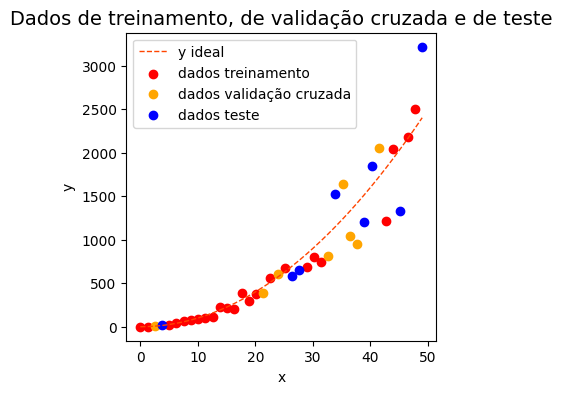

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y ideal", lw=1)
ax.set_title("Dados de treinamento, de validação cruzada e de teste",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",    label="dados treinamento")
ax.scatter(X_cv, y_cv, color = "orange",    label="dados validação cruzada")
ax.scatter(X_test, y_test,   color = "blue",   label="dados teste")

ax.legend(loc='upper left')
plt.show()

## Analisando modelos que sobreestimam dados (overfitting/high variance) e modelos que subestimam dados (underfitting/high bias)

No exemplo que trabalhamos anteriormente, ficou claro que o grau do modelo polinomial estava muito elevado, fazendo com que esse modelo sobreestimasse os dados. Como podemos fazer para escolher a ordem ideal?

Resposta: os erros de treinamento e de validação cruzada podem nos fornecer uma dica. Especificamente, podemos calcular tais erros considerando diferentes ordens para o polinômio. Quando a ordem começar a ficar muito grande, a performance para os dados de validação cruzada começará a deteriorar.

Veremos isso abaixo.

### Encontrando a ordem ótima

Abaixo nós treinamos modelos com 9 ordens diferentes. Para facilitar, continuaremos a utilizar o scikit-learn

In [12]:
max_degree = 9                               # maior ordem que será testada
err_train  = np.zeros(max_degree)            # conterá os erros de treinamento para cada ordem
err_cv     = np.zeros(max_degree)            # conterá os erros de validação cruzada para cada ordem
x          = np.linspace(0,int(X.max()),100)
y_prev     = np.zeros((100,max_degree))      # as colunas conterão as previsões para cada ordem

for degree in range(max_degree):
    modelo = lin_model(degree+1)
    modelo.fit(X_train, y_train)
    yhat              = modelo.predict(X_train)
    err_train[degree] = modelo.mse(y_train, yhat)
    yhat              = modelo.predict(X_cv)
    err_cv[degree]    = modelo.mse(y_cv, yhat)
    y_prev[:,degree]  = modelo.predict(x)

optimal_degree = np.argmin(err_cv)+1

print("ordem ótima encontrada: ", optimal_degree)

ordem ótima encontrada:  2


Abaixo nós plotamos os resultados obtidos:

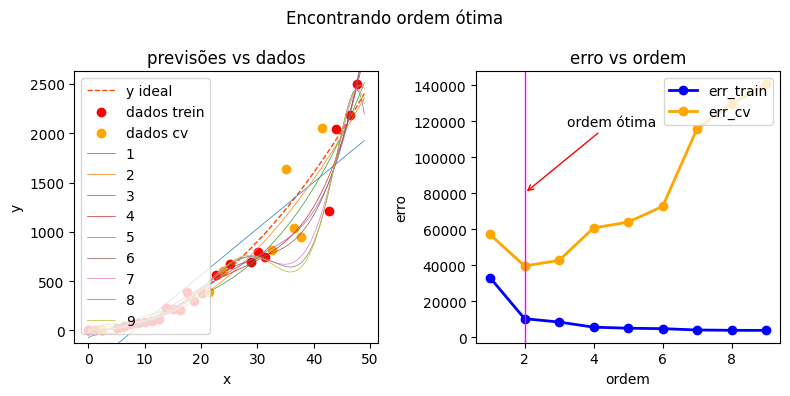

In [13]:
plt.close("all")

fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax[0].set_title("previsões vs dados",fontsize = 12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y ideal", lw=1)
ax[0].scatter(X_train, y_train, color = "red",           label="dados trein")
ax[0].scatter(X_cv, y_cv,       color = "orange", label="dados cv")
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
for i in range(0,max_degree):
    ax[0].plot(x, y_prev[:,i],  lw=0.5, label=f"{i+1}")
ax[0].legend(loc='upper left')

ax[1].set_title("erro vs ordem",fontsize = 12)
cpts = list(range(1, max_degree+1))
ax[1].plot(cpts, err_train[0:], marker='o',label="err_train", lw=2,  color = "blue")
ax[1].plot(cpts, err_cv[0:],    marker='o',label="err_cv",  lw=2, color = "orange")
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].axvline(optimal_degree, lw=1, color = "magenta")
ax[1].annotate("ordem ótima", xy=(optimal_degree,80000),xycoords='data',
            xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3",
                               color="red", lw=1))
ax[1].set_xlabel("ordem")
ax[1].set_ylabel("erro")
ax[1].legend(loc='upper right')
fig.suptitle("Encontrando ordem ótima",fontsize = 12)
plt.tight_layout()

plt.show()

A figura acima demonstra que separar os dados em dois grupos, onde um grupo de dados é mostrado ao modelo durante seu treinamento e outro não, pode ser uma estratégia muito útil para determinar se um modelo está sobreestimando (overfitting) ou subestimando (underfitting) os dados.

- No gráfico da esquerda, as linhas sólidas representam as previsões feitas pelos modelos de diferentes ordens. Um modelo polinomial de ordem 1 produz uma reta que intercepta algumas poucas amostras de dados. Já um modelo de ordem 9 aproxima muito bem os dados de treinamento.
- Já no gráfico da esquerda:
    - O erro nos dados de treinamento (azul) decai a medida com que a complexidade do modelo aumenta (conforme esperado, não é?)
    - O erro nos dados de validação cruzada (CV) decai inicialmente até um certo ponto, mas depois passa a aumentar à medida com que o aumenta começa a sobreestimar os dados (caracterizando uma falha na generalização do modelo para novos dados)
      
Observação final: O comportamento mais geral presente nos dados é o que queremos modelar.


### Encontrando o parâmetro de regularização $\lambda$ ótimo

Em aulas anteriores, nós já aprendemos que podemos utilizar a *regularização* para reduzir o overfitting. Nesse contexto, podemos usar a mesma metodologia que acabamos de usar para selecionar a ordem ótima para ajustar o parâmetro de regularização $\lambda$ ótimo para esse nosso problema.

Vamos demonstrar isso iniciando com um polinomio de ordem elevada e variando o parâmetro de regularização.

In [14]:
lambdas          = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
qtdade_lambdas   = len(lambdas)
degree           = 10              # ordem do polinômio
err_train        = np.zeros(qtdade_lambdas)
err_cv           = np.zeros(qtdade_lambdas)
x                = np.linspace(0,int(X.max()),100)
y_prev           = np.zeros((100,qtdade_lambdas))

for i in range(qtdade_lambdas):
    lambda_= lambdas[i]
    modelo = lin_model(degree, regularization=True, lambda_=lambda_)
    modelo.fit(X_train, y_train)
    yhat         = modelo.predict(X_train)
    err_train[i] = modelo.mse(y_train, yhat)
    yhat         = modelo.predict(X_cv)
    err_cv[i]    = modelo.mse(y_cv, yhat)
    y_prev[:,i]  = modelo.predict(x)

optimal_reg_idx = np.argmin(err_cv) # posição do vetor lambda_intervalo que contém o lambda ótimo

print("lambda ótimo: ", lambdas[optimal_reg_idx])

lambda ótimo:  1.0


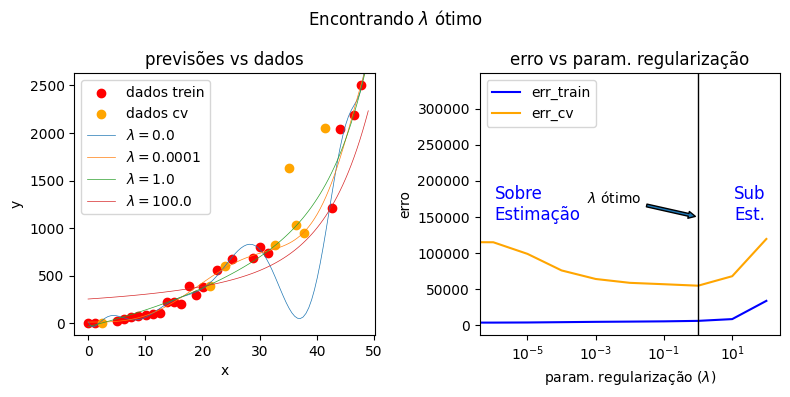

In [15]:
plt.close("all")

fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax[0].set_title("previsões vs dados",fontsize = 12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].scatter(X_train, y_train, color = "red",           label="dados trein")
ax[0].scatter(X_cv, y_cv,       color = "orange", label="dados cv")
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
for i in (0,3,7,9):
    ax[0].plot(x, y_prev[:,i],  lw=0.5, label=f"$\lambda =${lambdas[i]}")
ax[0].legend()

ax[1].set_title("erro vs param. regularização",fontsize = 12)
ax[1].plot(lambdas, err_train[:], label="err_train", color = "blue")
ax[1].plot(lambdas, err_cv[:],    label="err_cv",    color = "orange")
ax[1].set_xscale('log')
ax[1].set_ylim(*ax[1].get_ylim())
opt_x = lambdas[optimal_reg_idx]
ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
ax[1].annotate("$\lambda$ ótimo", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
              arrowprops={'arrowstyle':'simple'})
ax[1].set_xlabel("param. regularização ($\lambda$)")
ax[1].set_ylabel("erro")
fig.suptitle("Encontrando $\lambda$ ótimo",fontsize = 12)
ax[1].text(0.05,0.44,"Sobre\nEstimação",fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
ax[1].text(0.95,0.44,"Sub\nEst.",    fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

Acima, os gráficos mostram que, conforme o parâmetro de regularização cresce, o modelo deixa de sobreestimar os dados e passa a subestimar os dados. O ponto ótimo ocorre no meio do caminho (entre esses dois momentos). A linha vertical no gráfico da direita mostra um valor ótimo para $\lambda$. Nesse exemplo, a ordem do polinômio foi definida como 10.


### Aumentar a quantidade de dados (m) reduz o overfitting, aumentando a capacidade de generalização

Quando um modelo está sobreestimando os dados, coletar mais dados pode melhorar sua performance. Veremos isso abaixo.

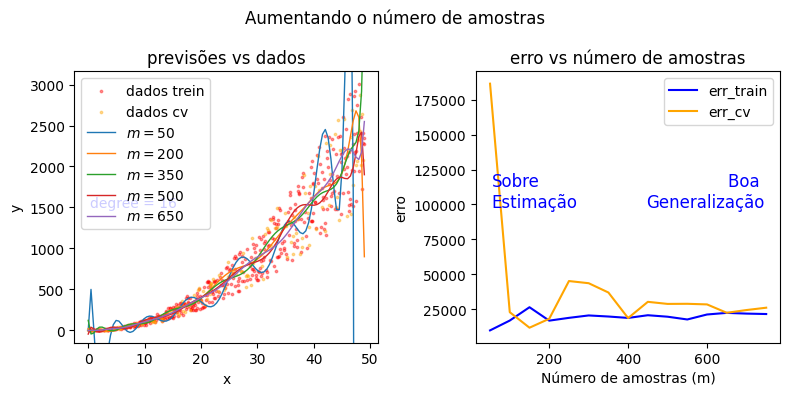

In [16]:
m         = 50
m_interv  = np.array(m*np.arange(1,16))
qtdade_m  = m_interv.shape[0]
degree    = 16
err_train = np.zeros(qtdade_m)
err_cv    = np.zeros(qtdade_m)
y_prev    = np.zeros((100,qtdade_m))

for i in range(qtdade_m):
    # gerando dados com base em valores do tipo x^2 com adição de ruído
    seed    = 5  # semente do gerador de números aleatórios
    escala  = 0.7 # escala do ruído
    m       = m_interv[i]  # número de amostras
    X       = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = X**2
    y       = y_ideal + escala * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = X

    x                          = np.linspace(0,int(X.max()),100)
    X_train, X_, y_train, y_   = train_test_split(X,y,test_size=0.40, random_state=1)
    X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

    modelo       = lin_model(degree)  # testaremos sem regularização
    modelo.fit(X_train, y_train)
    yhat         = modelo.predict(X_train)
    err_train[i] = modelo.mse(y_train, yhat)
    yhat         = modelo.predict(X_cv)
    err_cv[i]    = modelo.mse(y_cv, yhat)
    y_prev[:,i]  = modelo.predict(x)


# abaixo plotamos os resultados para as diferentes quantidades de amostras testadas.
fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax[0].set_title("previsões vs dados",fontsize = 12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].scatter(X_train, y_train, color = "red",           s=3, label="dados trein", alpha=0.4)
ax[0].scatter(X_cv, y_cv,       color = "orange", s=3, label="dados cv",    alpha=0.4)
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
for i in range(0,len(m_interv),3):
    ax[0].plot(x, y_prev[:,i],  lw=1, label=f"$m =${m_interv[i]}")
ax[0].legend(loc='upper left')
ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = "blue")

ax[1].set_title("erro vs número de amostras",fontsize = 12)
ax[1].plot(m_interv, err_train[:], label="err_train", color = "blue")
ax[1].plot(m_interv, err_cv[:],    label="err_cv",    color = "orange")
ax[1].set_xlabel("Número de amostras (m)")
ax[1].set_ylabel("erro")
fig.suptitle("Aumentando o número de amostras",fontsize = 12)
ax[1].text(0.05,0.5,"Sobre\nEstimação",        fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
ax[1].text(0.95,0.5,"Boa \nGeneralização", fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
ax[1].legend()
plt.tight_layout()
plt.show()

Os dois gráficos acima mostram que, quando um modelo encontra-se sobreestimando os dados, adicionar novas amostras melhora sua perfomance. Note as curvas no gráfico da esquerda. A curva final com o maior valor de $m$ é suave e captura a tendência presente nos dados. No gráfico da direita, conforme o número de amostras aumenta, a performance dos dados de treinamento e de validação cruzada convergem para valores similares. Note que as curvas não são tão suaves quanto geralmente se vê em aulas teóricas sobre o assunto. Isso também é esperado, pois trata-se de um problema real e prático.

Observação final: Mais dados tende a melhorar a capacidade de generalização do modelo.


## Parabéns!

Com este código, você aprendeu que:

* Criando três conjuntos de dados (treinamento, validação-cruzada e teste) permite que você
    * treine seus parâmetros $W,B$ com base nos dados de treinamento
    * use os dados de validação-cruzada para otimizar os hiperparâmetros tais como complexidade do modelo, parâmetro de regularização e número de amostras
    * estime a performance verdadeira do seu modelo com base nos dados de teste
* comparar performance em termos de treinamento versus validação-cruzada permite que você identifique overfitting e underfitting